# NN for MNIST classification

In [16]:
# Import the numpy library for matrix manipulations etc.
import numpy as np
import pandas as pd
import os
import sys

# Set up the graphics by importing the matplotlib plotting library
import matplotlib.pyplot as plt

import keras as kr
from keras.models import Sequential
from keras.layers import Dense

# Load data
from keras.datasets import fashion_mnist 
from keras.datasets import mnist 

(train_X,train_Y), (test_X,test_Y) = mnist.load_data()

image_dim = 28
image_size = image_dim*image_dim

trainX_flat = train_X.reshape(-1, image_size)
testX_flat  = test_X.reshape(-1, image_size)

In [2]:
def display_image(image_array, clim=None):
    """ Show a single image with colorbar. Image given in 1D or 2D representation. """
    
    plt.imshow(np.reshape(image_array,[28,28]), interpolation='nearest', cmap='binary')
    if clim is None:
        plt.clim([image_array.min(),image_array.max()])
    else:
        plt.clim(clim)
        
    plt.colorbar()
    plt.show()

In [3]:
class NN_MNIST_classifier:
    "Aboutaleb class for loading and training a neural net with the MNIST data."
    
    def __init__(self, trainX, trainY, testX, testY, layers, activationFunc='sigmoid', lossFunc = 'categorical_crossentropy', optimizer = 'adam'):

        # Set images properties.
        self.trainX = self.load_images(trainX)
        self.testX  = self.load_images(testX)
        self.trainY = self.to_one_hot_encoding(trainY)
        self.testY  = self.to_one_hot_encoding(testY)
        
        self.image_size  = self.trainX.shape[-1] 
        self.trainX_size = len(self.trainX)
        
        # Set network properties.
        self.layers         = layers
        self.activationFunc = activationFunc
        self.lossFunc       = lossFunc
        self.optimizer      = optimizer
        
        # Build and train network.
        self.build_network()
        self.compile_network()
        
    def load_images(self, images):
        
        if len(images.shape) < 3:
            return images
        
        image_dim = images.shape[-1]
        
        return images.reshape(-1, image_dim*image_dim)

    # Convert lablels to one-hot encoding.
    def to_one_hot_encoding(self, labels):   
        
        if len(labels.shape) == 2:
            return labels

        train_Y_onehot = np.array([[0]*10]*len(labels))
        for idx in range(len(train_Y_onehot)):
            train_Y_onehot[idx][labels[idx]] = 1
            
        return train_Y_onehot
        
    def build_network(self):
        net=kr.models.Sequential()
        net.add(kr.layers.Dense(self.layers[1], input_shape=(self.image_size,), activation=self.activationFunc))
        if(len(self.layers)>3):
            for li in self.layers[2:-1]:
                net.add(kr.layers.Dense(li, activation=self.activationFunc))
        net.add(kr.layers.Dense(self.layers[-1], activation='softmax'))
        self.net = net
            
    def compile_network(self):
        self.net.compile(loss=self.lossFunc,
                         optimizer=self.optimizer,
                         metrics=['categorical_accuracy'])
            
    def train_network(self, batch_size=100, epochs=30):
        self.history = self.net.fit(self.trainX, self.trainY, batch_size=batch_size, epochs=epochs)
        
    def test_network(self):
        testX_noise_props   = self.net.predict_on_batch(self.testX)
        testX_noise_results = np.argmax(testX_noise_props, axis=1)
        accuracy            = sum((np.argmax(self.testY, axis=1) - testX_noise_results) == 0)/len(self.testY) 
        
        return accuracy
        

## Original MNIST training example

### Create and fit NN

In [34]:
NN_default = NN_MNIST_classifier(train_X, train_Y, test_X, test_Y, layers = [image_size, 350, 350, 100, 10])

In [35]:
NN_default.train_network(epochs=15)

Epoch 1/15
60000/60000 [==============================] - 11s 188us/step - loss: 0.5349 - categorical_accuracy: 0.8542
Epoch 2/15
60000/60000 [==============================] - 10s 174us/step - loss: 0.2757 - categorical_accuracy: 0.9152
Epoch 3/15
60000/60000 [==============================] - 11s 192us/step - loss: 0.2446 - categorical_accuracy: 0.9249
Epoch 4/15
60000/60000 [==============================] - 10s 175us/step - loss: 0.2213 - categorical_accuracy: 0.9307
Epoch 5/15
60000/60000 [==============================] - 10s 165us/step - loss: 0.2170 - categorical_accuracy: 0.9327
Epoch 6/15
60000/60000 [==============================] - 10s 171us/step - loss: 0.2076 - categorical_accuracy: 0.9333
Epoch 7/15
60000/60000 [==============================] - 10s 174us/step - loss: 0.2043 - categorical_accuracy: 0.9356
Epoch 8/15
60000/60000 [==============================] - 10s 168us/step - loss: 0.1935 - categorical_accuracy: 0.9388
Epoch 9/15
60000/60000 [========================

In [36]:
NN_default.test_network()

0.9468

## Images distrorted with noise

In [151]:
def image_with_normal_noise(images_flat, mean = 0., sigma=25):
    """ Add normal distributed noise to list of 1D images. """
    
    images_flat_double = np.array(images_flat)
    images_flat_double = images_flat_double.astype(np.double)

    image_size = images_flat_double.shape[-1]
    image_noise = np.random.normal(mean, sigma, (len(images_flat_double), image_size))
    
    return images_flat_double + image_noise

In [194]:
def image_with_salt_pepper_noise(images_flat, frac = 0.1):
    """ Add salt-pepper noise (spickles) to list of 1D images. """

    images_flat_double = np.array(images_flat)
    images_flat_double = images_flat_double.astype(np.double)

    image_size = images_flat_double.shape[-1]
    N_images   = len(images_flat_double)
    
    N_salt_pepper_pixels = int(np.round(frac * image_size,0))
    
    images_salt_pepper_pixels = np.random.randint(0, image_size, N_salt_pepper_pixels * N_images).reshape(-1, N_salt_pepper_pixels)
    
    for image_idx, salt_pepper_pixels in enumerate(images_salt_pepper_pixels):
        images_flat_double[image_idx][salt_pepper_pixels] = 255.
    
    return images_flat_double

In [30]:
def image_occlusion(images_flat, horizontal=True, second_half=True):
    """ Remove half of the images. Select horizontal/vertical and first/second half. """

    image_dim  = 28
    image_size = image_dim*image_dim
    N_images   = len(images_flat)
    images_occ = np.array(images_flat).copy()
    
    occ_filter = []
    if horizontal:
        # remove horizontal half
        half_size = int(0.5*image_dim*image_dim)
        block1 = np.ones((N_images, half_size), np.uint8)
        block2 = np.zeros((N_images, half_size), np.uint8)
        occ_filter = np.concatenate([block1,block2], axis=1)
    else:
        # remove vertical half
        linefilter = np.concatenate([np.ones(int(0.5*image_dim), np.uint8), np.zeros(int(0.5*image_dim), np.uint8)])
        occ_filter = np.concatenate([linefilter]*image_dim)
        
    if second_half:
        occ_filter = 1 - occ_filter
    
    return images_occ * occ_filter

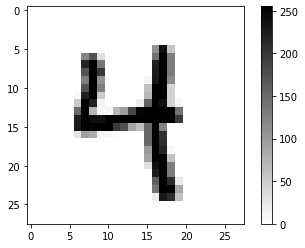

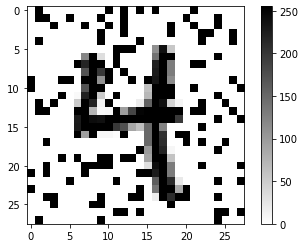

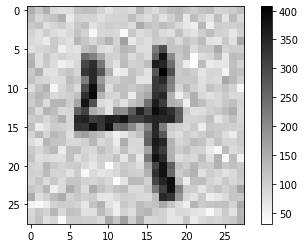

In [200]:
test_idx = np.random.randint(len(test_X))
sample_image_flat    = test_X[test_idx].reshape(-1,image_size)
sample_image_flat_sp = image_with_salt_pepper_noise(sample_image_flat, 0.2)
sample_image_flat_nm = image_with_normal_noise(sample_image_flat, 100)

display_image(sample_image_flat)
display_image(sample_image_flat_sp)
display_image(sample_image_flat_nm)

### Predict using noise free net on noisy images 

In [ ]:
sigma_list = np.arange(0, 200, 10)
accuracy_list = []
for sigma in sigma_list:
    
    testX_flat_noise  = image_with_normal_noise(testX_flat, 0., sigma)
    accuracy_list.append(NN_default.test_network())    
    
    print('Training accuray with noise ($\\sigma$ =', sigma, '):', accuracy_list[-1])

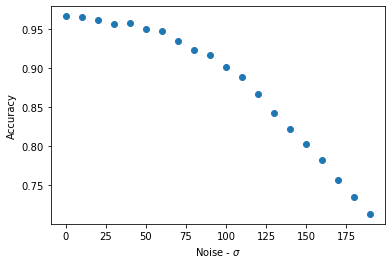

In [167]:
plt.plot(sigma_list, accuracy_list, 'o')
plt.xlabel('Noise - $\\sigma$')
plt.ylabel('Accuracy')
plt.show()

### Training: Images with normal distributed noise

In [198]:
trainX_flat_noise_normal = image_with_normal_noise(trainX_flat, 0., 100.)
testX_flat_noise_normal  = image_with_normal_noise(testX_flat,  0., 100.)

trainX_flat_noise_sp = image_with_salt_pepper_noise(trainX_flat, 0.2)
testX_flat_noise_sp  = image_with_salt_pepper_noise(testX_flat,  0.2)

In [232]:
NN_noise_normal = NN_MNIST_classifier(trainX_flat_noise_normal, train_Y, testX_flat_noise_normal, test_Y, layers = [image_size, 350, 350, 100, 10])
NN_noise_normal.train_network(epochs=30)
NN_noise_normal.test_network()

Epoch 1/30
60000/60000 [==============================] - 11s 185us/step - loss: 0.8088 - categorical_accuracy: 0.7556
Epoch 2/30
60000/60000 [==============================] - 12s 195us/step - loss: 0.4559 - categorical_accuracy: 0.8556
Epoch 3/30
60000/60000 [==============================] - 11s 182us/step - loss: 0.3942 - categorical_accuracy: 0.8751
Epoch 4/30
60000/60000 [==============================] - 8s 138us/step - loss: 0.3642 - categorical_accuracy: 0.8841
Epoch 5/30
60000/60000 [==============================] - 9s 145us/step - loss: 0.3364 - categorical_accuracy: 0.8937
Epoch 6/30
60000/60000 [==============================] - 8s 139us/step - loss: 0.3154 - categorical_accuracy: 0.8978
Epoch 7/30
60000/60000 [==============================] - 9s 149us/step - loss: 0.2948 - categorical_accuracy: 0.9053
Epoch 8/30
60000/60000 [==============================] - 9s 146us/step - loss: 0.2731 - categorical_accuracy: 0.9123
Epoch 9/30
60000/60000 [=============================

0.9309

In [ ]:
sigma_list = np.arange(0, 200, 10)
accuracy_noise_list = []
for sigma in sigma_list:
    
    testX_flat_noise  = image_with_normal_noise(testX_flat, 0., sigma)
    accuracy_noise_list.append(NN_noise_normal.test_network())
    
    print('Training accuray with noise ($\\sigma$ =', sigma, '):', accuracy_noise_list[-1])

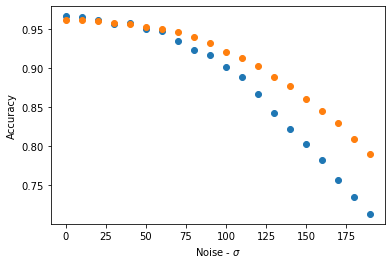

In [172]:
plt.plot(sigma_list, accuracy_list, 'o')
plt.plot(sigma_list, accuracy_noise_list, 'o')
plt.xlabel('Noise - $\\sigma$')
plt.ylabel('Accuracy')
plt.show()

### Training: Images with salt-and-pepper noise

In [231]:
NN_noise_sp = NN_MNIST_classifier(trainX_flat_noise_sp, train_Y, testX_flat_noise_sp, test_Y, layers = [image_size, 350, 350, 100, 10])
NN_noise_sp.train_network(epochs=30)
NN_noise_sp.test_network()

Epoch 1/30
60000/60000 [==============================] - 11s 191us/step - loss: 1.0469 - categorical_accuracy: 0.6746
Epoch 2/30
60000/60000 [==============================] - 12s 201us/step - loss: 0.7494 - categorical_accuracy: 0.7503
Epoch 3/30
60000/60000 [==============================] - 10s 160us/step - loss: 0.7155 - categorical_accuracy: 0.7634
Epoch 4/30
60000/60000 [==============================] - 9s 152us/step - loss: 0.6753 - categorical_accuracy: 0.7740
Epoch 5/30
60000/60000 [==============================] - 8s 133us/step - loss: 0.6432 - categorical_accuracy: 0.7855
Epoch 6/30
60000/60000 [==============================] - 9s 147us/step - loss: 0.6189 - categorical_accuracy: 0.7950
Epoch 7/30
60000/60000 [==============================] - 9s 146us/step - loss: 0.6227 - categorical_accuracy: 0.7915
Epoch 8/30
60000/60000 [==============================] - 9s 154us/step - loss: 0.5814 - categorical_accuracy: 0.8060
Epoch 9/30
60000/60000 [=============================

0.844

### Occlude images

In [31]:
trainX_flat_occ_hor1 = image_occlusion(trainX_flat, horizontal=True, second_half=True)
testX_flat_occ_hor1 = image_occlusion(testX_flat, horizontal=True, second_half=True)

trainX_flat_occ_hor2 = image_occlusion(trainX_flat, horizontal=True, second_half=False)
testX_flat_occ_hor2 = image_occlusion(testX_flat, horizontal=True, second_half=False)

trainX_flat_occ_ver1 = image_occlusion(trainX_flat, horizontal=False, second_half=True)
testX_flat_occ_ver1 = image_occlusion(testX_flat, horizontal=False, second_half=True)

trainX_flat_occ_ver2 = image_occlusion(trainX_flat, horizontal=False, second_half=False)
testX_flat_occ_ver2 = image_occlusion(testX_flat, horizontal=False, second_half=False)

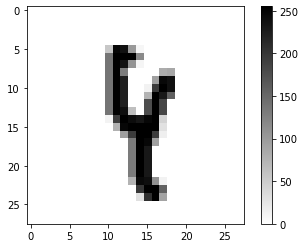

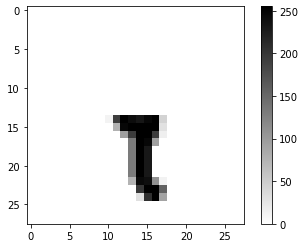

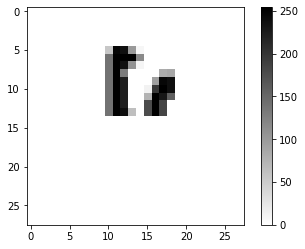

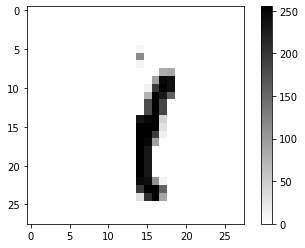

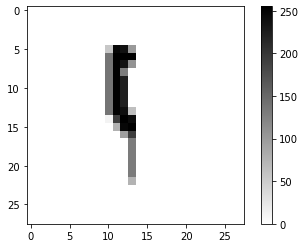

In [44]:
test_idx = np.random.randint(len(testX_flat_occ))
display_image(testX_flat[test_idx])
display_image(testX_flat_occ_hor1[test_idx])
display_image(testX_flat_occ_hor2[test_idx])
display_image(testX_flat_occ_ver1[test_idx])
display_image(testX_flat_occ_ver2[test_idx])

In [51]:
np.argmax(NN_occ_hor1.net.predict_on_batch(np.array([testX_flat_occ_hor1[test_idx]])))

1

In [37]:
NN_occ_hor1 = NN_MNIST_classifier(trainX_flat_occ_hor1, train_Y, testX_flat_occ_hor1, test_Y, layers = [image_size, 350, 350, 100, 10])
NN_occ_hor1.train_network(epochs=15)
NN_occ_hor1.test_network()

Epoch 1/15
60000/60000 [==============================] - 12s 204us/step - loss: 0.7143 - categorical_accuracy: 0.7714
Epoch 2/15
60000/60000 [==============================] - 10s 171us/step - loss: 0.4656 - categorical_accuracy: 0.8359
Epoch 3/15
60000/60000 [==============================] - 11s 176us/step - loss: 0.4269 - categorical_accuracy: 0.8473
Epoch 4/15
60000/60000 [==============================] - 10s 170us/step - loss: 0.4150 - categorical_accuracy: 0.8490
Epoch 5/15
60000/60000 [==============================] - 11s 179us/step - loss: 0.3987 - categorical_accuracy: 0.8538
Epoch 6/15
60000/60000 [==============================] - 12s 194us/step - loss: 0.3929 - categorical_accuracy: 0.8555
Epoch 7/15
60000/60000 [==============================] - 11s 181us/step - loss: 0.3791 - categorical_accuracy: 0.8596
Epoch 8/15
60000/60000 [==============================] - 10s 174us/step - loss: 0.3703 - categorical_accuracy: 0.8618
Epoch 9/15
60000/60000 [========================

0.8739

In [38]:
NN_occ_hor2 = NN_MNIST_classifier(trainX_flat_occ_hor2, train_Y, testX_flat_occ_hor2, test_Y, layers = [image_size, 350, 350, 100, 10])
NN_occ_hor2.train_network(epochs=15)
NN_occ_hor2.test_network()

Epoch 1/15
60000/60000 [==============================] - 10s 166us/step - loss: 0.7206 - categorical_accuracy: 0.7908
Epoch 2/15
60000/60000 [==============================] - 9s 150us/step - loss: 0.4159 - categorical_accuracy: 0.8696
Epoch 3/15
60000/60000 [==============================] - 10s 164us/step - loss: 0.3780 - categorical_accuracy: 0.8807
Epoch 4/15
60000/60000 [==============================] - 10s 160us/step - loss: 0.3554 - categorical_accuracy: 0.8845
Epoch 5/15
60000/60000 [==============================] - 10s 166us/step - loss: 0.3418 - categorical_accuracy: 0.8901
Epoch 6/15
60000/60000 [==============================] - 10s 170us/step - loss: 0.3290 - categorical_accuracy: 0.8937
Epoch 7/15
60000/60000 [==============================] - 9s 155us/step - loss: 0.3132 - categorical_accuracy: 0.8980
Epoch 8/15
60000/60000 [==============================] - 10s 165us/step - loss: 0.3087 - categorical_accuracy: 0.8996
Epoch 9/15
60000/60000 [==========================

0.9106

In [39]:
NN_occ_ver1 = NN_MNIST_classifier(trainX_flat_occ_ver1, train_Y, testX_flat_occ_ver1, test_Y, layers = [image_size, 350, 350, 100, 10])
NN_occ_ver1.train_network(epochs=15)
NN_occ_ver1.test_network()

Epoch 1/15
60000/60000 [==============================] - 10s 169us/step - loss: 0.7296 - categorical_accuracy: 0.7806
Epoch 2/15
60000/60000 [==============================] - 10s 160us/step - loss: 0.4498 - categorical_accuracy: 0.8543
Epoch 3/15
60000/60000 [==============================] - 10s 168us/step - loss: 0.4018 - categorical_accuracy: 0.8673
Epoch 4/15
60000/60000 [==============================] - 10s 160us/step - loss: 0.3819 - categorical_accuracy: 0.8742
Epoch 5/15
60000/60000 [==============================] - 9s 154us/step - loss: 0.3644 - categorical_accuracy: 0.8796
Epoch 6/15
60000/60000 [==============================] - 10s 171us/step - loss: 0.3547 - categorical_accuracy: 0.8831
Epoch 7/15
60000/60000 [==============================] - 11s 176us/step - loss: 0.3381 - categorical_accuracy: 0.8866
Epoch 8/15
60000/60000 [==============================] - 11s 183us/step - loss: 0.3274 - categorical_accuracy: 0.8905
Epoch 9/15
60000/60000 [=========================

0.8982

In [40]:
NN_occ_ver2 = NN_MNIST_classifier(trainX_flat_occ_ver2, train_Y, testX_flat_occ_ver2, test_Y, layers = [image_size, 350, 350, 100, 10])
NN_occ_ver2.train_network(epochs=15)
NN_occ_ver2.test_network()

Epoch 1/15
60000/60000 [==============================] - 11s 179us/step - loss: 0.6396 - categorical_accuracy: 0.8181
Epoch 2/15
60000/60000 [==============================] - 10s 163us/step - loss: 0.3676 - categorical_accuracy: 0.8883
Epoch 3/15
60000/60000 [==============================] - 10s 175us/step - loss: 0.3324 - categorical_accuracy: 0.8974
Epoch 4/15
60000/60000 [==============================] - 10s 174us/step - loss: 0.3120 - categorical_accuracy: 0.9035
Epoch 5/15
60000/60000 [==============================] - 9s 158us/step - loss: 0.2903 - categorical_accuracy: 0.9093
Epoch 6/15
60000/60000 [==============================] - 10s 174us/step - loss: 0.2812 - categorical_accuracy: 0.9116
Epoch 7/15
60000/60000 [==============================] - 10s 169us/step - loss: 0.2683 - categorical_accuracy: 0.9152
Epoch 8/15
60000/60000 [==============================] - 11s 179us/step - loss: 0.2665 - categorical_accuracy: 0.9157
Epoch 9/15
60000/60000 [=========================

0.9289